In [1]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from importlib import reload

In [2]:
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [3]:
#Data Samples
TRAIN_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_parts/'
filename_bg = TRAIN_PATH + 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband_000.h5'
batch_size = 128
train_set_size = batch_size*50
nodes_n, feat_sz, particles_bg, A_bg, A_tilde_bg = prepr.prepare_data(filename_bg,train_set_size,0,train_set_size+1)

VALID_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband_parts'
filename_bg_valid = TRAIN_PATH + 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband_000.h5'
batch_size = 128
valid_set_size = batch_size*10
_,_, particles_bg_valid, A_bg_valid, A_tilde_bg_valid = prepr.prepare_data(filename_bg,valid_set_size,0,valid_set_size+1)

Number of jets = 12571
Number of constituents (nodes) = 100
Number of features = 3


/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:38: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


Number of jets = 2518
Number of constituents (nodes) = 100
Number of features = 3


In [4]:
print(particles_bg.shape, A_tilde_bg.shape, A_bg.shape)

(6400, 100, 3) (6400, 100, 100) (6400, 100, 100)


AttributeError: 'numpy.ndarray' object has no attribute 'nan'

# Autoencoder

In [6]:
gnn = models.GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), run_eagerly=True)  #learning rate 0.001 worked

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
graph_convolution (GraphConvolu (None, 100, 6)       42          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_1 (GraphConvo (None, 100, 8)       104         graph_convolution[0][0

In [7]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
gnn.fit((particles_bg, A_tilde_bg), A_bg, epochs=50, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/50
74/74 [==============================] - 8s 111ms/step - val_loss: 0.4226
Epoch 2/50
74/74 [==============================] - 7s 95ms/step - val_loss: 0.4060
Epoch 3/50
74/74 [==============================] - 8s 105ms/step - val_loss: 0.4033
Epoch 4/50
74/74 [==============================] - 8s 111ms/step - val_loss: 0.4018
Epoch 5/50
74/74 [==============================] - 8s 108ms/step - val_loss: 0.4009
Epoch 6/50
74/74 [==============================] - 8s 106ms/step - val_loss: 0.4003
Epoch 7/50
74/74 [==============================] - 8s 107ms/step - val_loss: 0.3999
Epoch 8/50
74/74 [==============================] - 8s 106ms/step - val_loss: 0.3996
Epoch 9/50
74/74 [==============================] - 8s 103ms/step - val_loss: 0.3994
Epoch 10/50
74/74 [==============================] - 7s 93ms/step - val_loss: 0.3993
Epoch 11/50
74/74 [==============================] - 8s 107ms/step - val_loss: 0.3992
Epoch 12/50
74/74 [==============================] - 8s 106ms/ste

## Predict BG and Sig

In [11]:
#Prepare signal and background (for testing) samples

#signal
SIG_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV_NEW_parts/'
filename_sig = SIG_PATH + 'RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV_NEW_concat_001.h5'
_,_, particles_sig, A_sig, A_tilde_sig = prepr.prepare_data(filename_sig,5000,0,5000)
#background test 
_,_, particles_bg_test, A_bg_test, A_tilde_bg_test = prepr.prepare_data(filename_bg,5000,train_set_size+1,train_set_size+5000)


Number of jets = 9966
Number of constituents (nodes) = 100
Number of features = 3


/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:38: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


Number of jets = 9840
Number of constituents (nodes) = 100
Number of features = 3


In [12]:
z_sig, A_pred_sig = gnn((particles_sig, A_tilde_sig))
z_bg_test, A_pred_bg_test = gnn((particles_bg_test, A_tilde_bg_test))
loss_signal = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_sig, A_pred_sig), axis=(1,2)).numpy() #predicted adjecny, but not set to 0/1 yet
loss_bg = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_bg_test, A_pred_bg_test), axis=(1,2)).numpy()

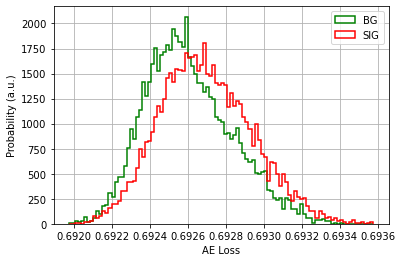

In [13]:
max_score = np.max(np.max(loss_signal))#,np.max(loss_bg_dist))
min_score = np.max(np.min(loss_bg))#,np.max(loss_bg_dist))
# plot BG
plt.figure()
plt.hist(loss_bg, bins=100, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5,color='g')
plt.hist(loss_signal, bins=100, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5,color='r')
#plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Probability (a.u.)")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# GCN VAE

In [5]:
def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)



In [94]:
import models.losses as losses
reload(losses)
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [95]:
gcnvae = models.GCNVariationalAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh,latent_dim=50,kl_warmup_time=10)
gcnvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

100
Model: "functional_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
graph_convolution_51 (GraphConv (None, 100, 2)       14          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
flatten_20 (Flatten)            (None, 200)          0           graph_convolution

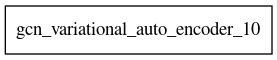

In [96]:
tf.keras.utils.plot_model(gcnvae, show_shapes=True)

In [97]:
custom_callback = models.KLWarmupCallback()

In [107]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=2),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2),custom_callback] 
gcnvae.fit(particles_bg, A_tilde_bg, epochs=30, batch_size=128, validation_data = ((particles_bg_valid, A_bg_valid)), callbacks=callbacks) 

Epoch 1/30
50/50 [==============================] - 4s 72ms/step - loss: 0.8953 - loss_reco: 0.8953 - loss_latent: 2.4842e-04 - beta_kl_warmup: 0.0000e+00 - val_loss: 0.9874 - val_loss_reco: 0.9874 - val_loss_latent: 0.0289
Epoch 2/30
50/50 [==============================] - 4s 75ms/step - loss: 0.8949 - loss_reco: 0.8948 - loss_latent: 9.2048e-05 - beta_kl_warmup: 0.1000 - val_loss: 0.9989 - val_loss_reco: 0.9699 - val_loss_latent: 0.0289
Epoch 3/30
50/50 [==============================] - 3s 68ms/step - loss: 0.8945 - loss_reco: 0.8945 - loss_latent: 2.4275e-06 - beta_kl_warmup: 0.2000 - val_loss: 1.0310 - val_loss_reco: 0.9731 - val_loss_latent: 0.0289
Epoch 4/30
50/50 [==============================] - 3s 67ms/step - loss: 0.8943 - loss_reco: 0.8943 - loss_latent: 1.4110e-06 - beta_kl_warmup: 0.3000 - val_loss: 1.0823 - val_loss_reco: 0.9954 - val_loss_latent: 0.0289
Epoch 5/30
50/50 [==============================] - 4s 73ms/step - loss: 0.8912 - loss_reco: 0.8912 - loss_latent: 9

In [56]:
#background

In [13]:
_,_, particles_bg_test, A_bg_test, A_tilde_bg_test = prepr.prepare_data(filename_bg,2000,train_set_size+1,train_set_size+2000)


Number of jets = 3929
Number of constituents (nodes) = 100
Number of features = 3


In [14]:
#signal
SIG_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_NEW_parts/'
filename_sig = SIG_PATH + 'RSGraviton_WW_NARROW_13TeV_PU40_1.5TeV_NEW_concat_001.h5'
nodes_n, feat_sz, particles_sig, A_sig, A_tilde_sig = prepr.prepare_data(filename_sig,2000)


Number of jets = 363512
Number of constituents (nodes) = 100
Number of features = 3


In [157]:
loaded_1 = tf.keras.models.load_model(
    "output_model_saved_003", custom_objects={"GCNVariationalAutoEncoder": models.GCNVariationalAutoEncoder}
)


In [108]:
#Predict

#model = loaded_1
model = gcnvae

features_out_bg_test, z_bg_test, z_mean_bg_test, z_log_var_bg_test = model((particles_bg_test, A_tilde_bg_test))
features_out_bg_test = features_out_bg_test.numpy().astype('float32')
loss_bg = threeD_loss_manual(particles_bg_test.astype('float32'),features_out_bg_test)

features_out_sig, z_sig, z_mean_sig, z_log_var_sig = model((particles_sig, A_tilde_sig))
features_out_sig = features_out_sig.numpy().astype('float32')
loss_signal = threeD_loss_manual(particles_sig.astype('float32'),features_out_sig)

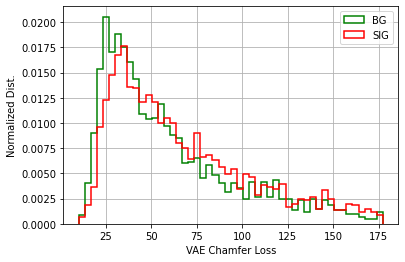

In [109]:
max_score = np.quantile(loss_signal,0.9)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
# plot BG
plt.figure()
plt.hist(loss_bg, bins=50, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5,color='g')
plt.hist(loss_signal, bins=50, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5,color='r')
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [101]:
loss_signal.mean()

89.00744

In [102]:
loss_bg.mean()

89.50076

In [12]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../vande/')))
sys.path.append(os.path.abspath(os.path.join('../pofah/')))

In [105]:
np.quantile(loss_bg,0.8)

114.77048797607422

In [106]:
np.quantile(loss_signal,0.8)

120.73636016845704